In [2]:
import pandas as pd
import numpy as np
# Libraries for Text Preprocessing
import re
import nltk
from nltk.corpus import stopwords
import textblob
from textblob import Word
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# Libraries for Visualization
import wordcloud
from plotly.offline import init_notebook_mode, iplot,plot
init_notebook_mode(connected = True)
import matplotlib.pyplot as plt
import plotly.express as px
# Libraries for Model
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split

<a id="1"></a>
# **LOAD and CHECK DATA**

In [3]:
train_df=pd.read_csv("../input/hotel-review/train.csv")

In [4]:
train_df.describe().T

count unique                                                top  \
User_ID       38932  38932                                            id10326   
Description   38932  38932  The room was kind of clean but had a VERY stro...   
Browser_Used  38932     11                                            Firefox   
Device_Used   38932      3                                            Desktop   
Is_Response   38932      2                                              happy   

               freq  
User_ID           1  
Description       1  
Browser_Used   7367  
Device_Used   15026  
Is_Response   26521

In [5]:
print("Total number of reviews in Train Data: {} ".format(len(train_df)))

Total number of reviews in Train Data: 38932 


### Check missing values:

In [6]:
train_df.isnull().sum()

User_ID         0
Description     0
Browser_Used    0
Device_Used     0
Is_Response     0
dtype: int64

<a id="2"></a>

# **VISUALIZATION**

In [7]:
fix_browser={"Google Chrome":0,"Chrome":0,
             "InternetExplorer":1,"Internet Explorer":1,"IE":1,"Edge":1,
            "Mozilla":2,"Firefox":2,"Mozilla Firefox":2,
             "Opera":3,"Safari":4}
train_df=train_df.replace({"Browser_Used":fix_browser})
test_df=train_df.replace({"Browser_Used":fix_browser})

rename_browser={0:"Google Chrome",1:"Internet Explorer",2:"Mozilla Firefox",3:"Opera",4:"Safari"}
train_df=train_df.replace({"Browser_Used":rename_browser})
test_df=train_df.replace({"Browser_Used":rename_browser})

In [8]:
fig=px.histogram(train_df,x="Browser_Used",title="Number of Browsers")
fig.show()

In [9]:
fig=px.histogram(train_df,x="Device_Used",title="Number of Devices")
fig.show()

In [10]:
fig=px.histogram(train_df,x="Is_Response",title="Number of Response")
fig.show()

<a id="3"></a>

# **PREPROCESSING**

In [11]:
df=pd.DataFrame()
df["text"]=train_df["Description"]
df["label"]=train_df["Is_Response"]
df.head()

text      label
0  The room was kind of clean but had a VERY stro...  not happy
1  I stayed at the Crown Plaza April -- - April -...  not happy
2  I booked this hotel through Hotwire at the low...  not happy
3  Stayed here with husband and sons on the way t...      happy
4  My girlfriends and I stayed here to celebrate ...  not happy

In [12]:
df.label=[1 if each == "happy" else 0 for each in df.label] # 1 for happy, 0 for not happy
df.head()

text  label
0  The room was kind of clean but had a VERY stro...      0
1  I stayed at the Crown Plaza April -- - April -...      0
2  I booked this hotel through Hotwire at the low...      0
3  Stayed here with husband and sons on the way t...      1
4  My girlfriends and I stayed here to celebrate ...      0

In [13]:
df["text"] = df["text"].apply(lambda x: x.lower())
df['text'] = df['text'].apply(lambda x: re.sub('[,\.!?:()"]', '', x))
df['text'] = df['text'].apply(lambda x: re.sub('[^a-zA-Z"]', ' ', x))
df['text'] = df['text'].apply(lambda x: x.strip())

In [14]:
sw=stopwords.words("english")
df["text"] = df["text"].apply(lambda x: " ".join(x for x in x.split() if x not in sw)) 

## **VISUALIZE COMMON WORDS**

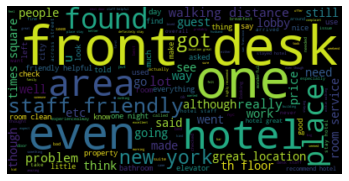

In [15]:
common_words=""
for i in df.text:
    i=str(i)
    tokens=i.split()
    common_words += " ".join(tokens) + " "
wordcloud=wordcloud.WordCloud().generate(common_words)
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()

In [16]:
tokenizer=Tokenizer(num_words=2000,split=" ")
tokenizer.fit_on_texts(df["text"].values)
X=tokenizer.texts_to_sequences(df["text"].values)
X=pad_sequences(X)

In [17]:
y=pd.get_dummies(df["label"])

<a id="4"></a>

# **MODEL**

In [18]:
model = Sequential()
model.add(Embedding(2000, 128,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
print(model.summary())

2022-09-23 16:22:49.566565: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 861, 128)          256000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 861, 128)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 2)                 130       
Total params: 305,538
Trainable params: 305,538
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

In [20]:
Y=y.values
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,random_state=42)
print("X Train: ",x_train.shape)
print("Y Train: ",y_train.shape)
print("X Test: ",x_test.shape)
print("Y Test: ",y_test.shape)

X Train:  (27252, 861)
Y Train:  (27252, 2)
X Test:  (11680, 861)
Y Test:  (11680, 2)


In [21]:
history=model.fit(x_train,y_train,epochs=3,batch_size=32,shuffle=True)

2022-09-23 16:22:51.537968: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/3
852/852 [==============================] - 2260s 3s/step - loss: 0.3644 - accuracy: 0.8454
Epoch 2/3
852/852 [==============================] - 2283s 3s/step - loss: 0.2938 - accuracy: 0.8811
Epoch 3/3
852/852 [==============================] - 2306s 3s/step - loss: 0.2670 - accuracy: 0.8944


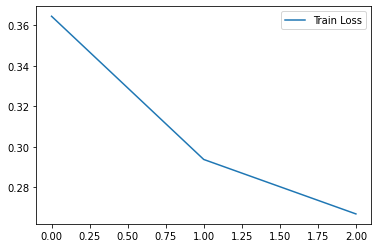

In [22]:
plt.plot(history.history['loss'],label='Train Loss')
plt.legend()
plt.show()

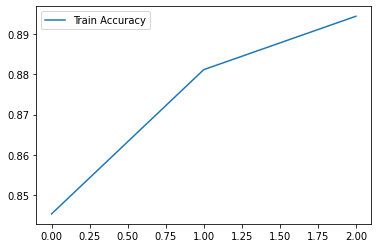

In [23]:
plt.plot(history.history['accuracy'],label='Train Accuracy')
plt.legend()
plt.show()

<a id="5"></a>

# **EVALUATION**

In [24]:
validation_size=5000
x_val=x_test[-validation_size:]
y_val=y_test[-validation_size:]
x_test=x_test[:-validation_size]
y_test=y_test[:-validation_size]

score,acc=model.evaluate(x_test,y_test,verbose=2,batch_size=32)
print("SCORE: ",score)
print("ACCURACY: ",acc)

209/209 - 115s - loss: 0.3352 - accuracy: 0.8659
SCORE:  0.3352452218532562
ACCURACY:  0.8658682703971863


<a id="6"></a>

# **PREDICTION**

In [25]:
review=["The rooms stink. They are not clean. I requested a non smoking room and both rooms smelled like smoke. Bathrooms were gross and bugs were everywhere! ! The door did not seem secure and was not evened out so bugs got in easily. The second room was full of gnats."]
review_tok=tokenizer.texts_to_sequences(review)
review_pad=pad_sequences(review_tok,maxlen=80,dtype="int32",value=0)
prediction=model.predict(review_pad,batch_size=1,verbose=2)[0]
print("REVIEW: ",review)
print("----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
if(np.argmax(prediction)==0):
    print("NEGATIVE")
else:
    print("POSITIVE")

1/1 - 0s
REVIEW:  ['The rooms stink. They are not clean. I requested a non smoking room and both rooms smelled like smoke. Bathrooms were gross and bugs were everywhere! ! The door did not seem secure and was not evened out so bugs got in easily. The second room was full of gnats.']
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
NEGATIVE


In [26]:
review2=["Rooms, concierge services and party scene were great.. right in middle of downtown San Diego .. the restaurants and clubs were very good.. will definitely come back"]
review_tok2=tokenizer.texts_to_sequences(review2)
review_pad2=pad_sequences(review_tok2,maxlen=80,dtype="int32",value=0)
prediction=model.predict(review_pad2,batch_size=1,verbose=2)[0]
print("REVIEW: ",review2)
print("----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
if(np.argmax(prediction)==0):
    print("NEGATIVE")
else:
    print("POSITIVE")

1/1 - 0s
REVIEW:  ['Rooms, concierge services and party scene were great.. right in middle of downtown San Diego .. the restaurants and clubs were very good.. will definitely come back']
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
POSITIVE
